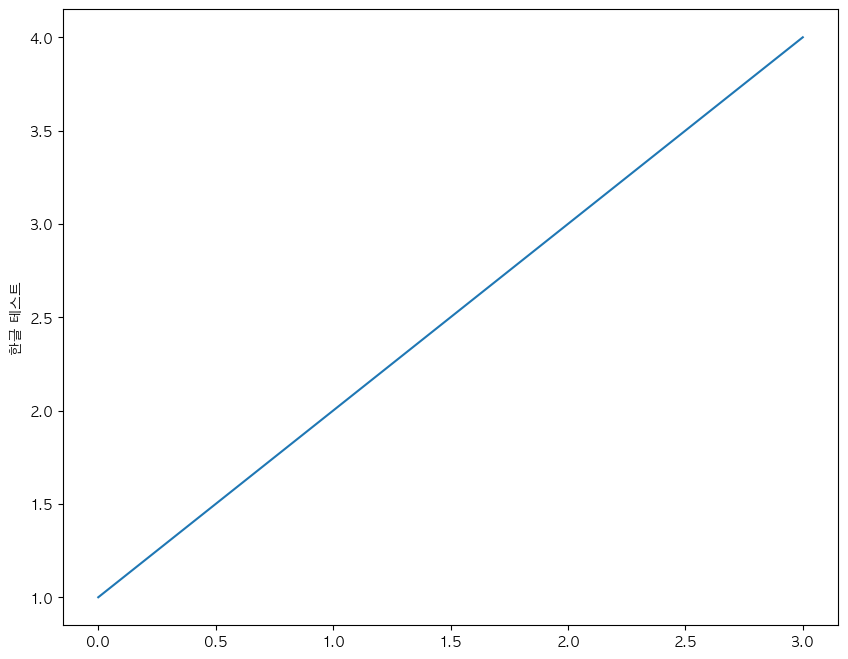

In [30]:
## import library
import trino
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


plt.rcParams['figure.figsize'] = [10, 8]

conn = trino.dbapi.connect(
    host='kakaoent-presto-adhoc.kakaoent.io',
    port=8443,
    user='samuel-ch',
    catalog='hadoop_kent',
    schema='default',                          # 사용할 Database 지정
    http_scheme='https',
    auth=trino.auth.BasicAuthentication("samuel-ch", "melon!Q2w3e"),  # 카카오 LDAP이 아닌 하둡 LDAP 입력
    http_headers={
        'X-Presto-User': 'samuel-ch',
        'X-Presto-Time-Zone': 'Asia/Seoul'
    },
)
cur = conn.cursor()

# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

cm = sns.light_palette("green", as_cmap=True)

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# AppleGothic 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 테스트 플롯
plt.plot([1, 2, 3, 4])
plt.ylabel('한글 테스트')
plt.show()

In [33]:
# 3개월 100원 프로모션 데이터 쿼리
promo_retention_query = '''
SELECT
    FST_DT AS YM
  , PROMO_GRP_NM
  , FST_PROD_CNT
  , IF(M1_PROD_CNT = 0, NULL, cast(M1_PROD_CNT  as double)/FST_PROD_CNT*100) AS M1_PROD_RATE
  , IF(M2_PROD_CNT = 0, NULL, cast(M2_PROD_CNT  as double)/FST_PROD_CNT*100) AS M2_PROD_RATE
  , IF(M3_PROD_CNT = 0, NULL, cast(M3_PROD_CNT  as double)/FST_PROD_CNT*100) AS M3_PROD_RATE
  , IF(M4_PROD_CNT = 0, NULL, cast(M4_PROD_CNT  as double)/FST_PROD_CNT*100) AS M4_PROD_RATE
  , IF(M5_PROD_CNT = 0, NULL, cast(M5_PROD_CNT  as double)/FST_PROD_CNT*100) AS M5_PROD_RATE
  , IF(M6_PROD_CNT = 0, NULL, cast(M6_PROD_CNT  as double)/FST_PROD_CNT*100) AS M6_PROD_RATE
  --, IF(M7_PROD_CNT = 0, NULL, cast(M7_PROD_CNT  as double)/FST_PROD_CNT*100) AS M7_PROD_RATE
  --, IF(M8_PROD_CNT = 0, NULL, cast(M8_PROD_CNT  as double)/FST_PROD_CNT*100) AS M8_PROD_RATE
  --, IF(M9_PROD_CNT = 0, NULL, cast(M9_PROD_CNT  as double)/FST_PROD_CNT*100) AS M9_PROD_RATE
  --, IF(M10_PROD_CNT= 0, NULL, cast(M10_PROD_CNT as double)/FST_PROD_CNT*100) AS M10_PROD_RATE
  --, IF(M11_PROD_CNT= 0, NULL, cast(M11_PROD_CNT as double)/FST_PROD_CNT*100) AS M11_PROD_RATE
  --, IF(M12_PROD_CNT= 0, NULL, cast(M12_PROD_CNT as double)/FST_PROD_CNT*100) AS M12_PROD_RATE
FROM (
    SELECT
        FST_DT
      , PROMO_GRP_NM
      , COUNT(DISTINCT FIRST_BUY_NO) AS FST_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 1, BUY_NO, NULL))  AS M1_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 2, BUY_NO, NULL))  AS M2_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 3, BUY_NO, NULL))  AS M3_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 4, BUY_NO, NULL))  AS M4_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 5, BUY_NO, NULL))  AS M5_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 6, BUY_NO, NULL))  AS M6_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 7, BUY_NO, NULL))  AS M7_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 8, BUY_NO, NULL))  AS M8_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 9, BUY_NO, NULL))  AS M9_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 10, BUY_NO, NULL)) AS M10_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 11, BUY_NO, NULL)) AS M11_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 12, BUY_NO, NULL)) AS M12_PROD_CNT
    FROM (
        SELECT
            DATE_FORMAT(FST_DT, '%Y-%m') AS FST_DT
          , FIRST_BUY_NO
          , PROMO_GRP_NM
          , DT
          , BUY_NO
          , IF(NEW_TERM = LAG(NEW_TERM) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), NEW_TERM+1, NEW_TERM) AS TERM
--          , DATE_DIFF('MONTH', DATE(DATE_FORMAT(FST_DT, '%Y-%m-01')), DATE(DATE(DATE_FORMAT(CURRENT_DATE, '%Y-%m-01')))) AS TEMP
        FROM (
            SELECT 
                FST_DT
              , FIRST_BUY_NO
              , PROMO_GRP_NM
              , MEMBER_KEY
              , DT
              , BUY_NO
              , CASE
                    WHEN (BF_TERM + 1) = TERM THEN TERM
                    WHEN (BF_TERM + 1) <> TERM AND (MONTH(BF_DT) = MONTH(DT)) THEN (TERM + 1)
                    ELSE TERM
                END AS NEW_TERM
            FROM (
                SELECT
                    FST_DT
                  , FIRST_BUY_NO
                  , PROMO_GRP_NM
                  , MEMBER_KEY
                  , DT
                  , BUY_NO
                  , TERM
                  , COALESCE(LAG(DT)     OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FST_DT) AS BF_DT
                  , COALESCE(LAG(BUY_NO) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FIRST_BUY_NO) AS BF_BUY_NO
                  , COALESCE(LAG(TERM)   OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), 0) AS BF_TERM
                FROM (
                    SELECT F1.DT AS FST_DT
                         , F1.FIRST_BUY_NO
                         , F1.PROMO_GRP_NM
                         , F1.MEMBER_KEY
                         , F2.BUY_NO
                         , F2.DT
                         , DATE_DIFF('MONTH', F1.DT, F2.DT) AS TERM
                    FROM (
                        SELECT T1.DT
                             , T1.FIRST_BUY_NO
                             , T1.BUY_NO
                             , T1.USER_MKEY AS MEMBER_KEY
                             , T5.PROMO_DC_GRP
                             , T3.PROMO_GRP_CD
                             , T6.PROMO_GRP_NM
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD T2  ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO T4 ON (T1.PROD_ID = T4.PROD_ID)
                        JOIN(
                            SELECT PROMO_DC_GRP_CD
                                 , PROMO_DC_GRP_NM
                                 , CASE
                                    WHEN PROMO_DC_GRP_CD IN (2,3,4) THEN '1개월 0원 + 장기할인'
                                    WHEN PROMO_DC_GRP_CD IN (5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,83,86,87,88,91,93,94,98,109) THEN '1개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (95,101,102) THEN '1개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (28,29,30,31,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) THEN '2개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (33,103) THEN '2개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,81,82,84,85,89,90,92,96,97,99,100,104,110,107,108) THEN '장기할인(3개월이상)'
                                    ELSE PROMO_DC_GRP_NM
                                   END AS PROMO_DC_GRP
                            FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO_DC_GRP
                        ) T5 ON T3.PROMO_DC_GRP_CD = T5.PROMO_DC_GRP_CD
                        left join hadoop_kent.melon_ma_stat_production.d_promo_grp t6 on t3.promo_grp_cd = t6.promo_grp_cd
                        WHERE T1.LOG_DATE BETWEEN '20231201' AND '20241231'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') BETWEEN '20231201' AND '20241231'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD = 1100 --IN (1100, 1200, 1201, 1205, 1203,1206,1207) /*신규 로직에서 1206 제외*/ 
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND PROD_PRT_CD = 20000  /*클럽 상품*/
                          AND T5.PROMO_DC_GRP = '3개월 100원'
                          AND T3.PROMO_GRP_CD <> 49
                        GROUP BY 1, 2, 3, 4,5, 6, 7

                    ) F1
                    LEFT OUTER JOIN (
                        SELECT DT
                             , FIRST_BUY_NO
                             , BUY_NO
                             , USER_MKEY AS MEMBER_KEY
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT  T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD               T2 ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO              T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO     T4 ON (T1.PROD_ID = T4.PROD_ID)
                        WHERE T1.LOG_DATE >= '20231201'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') >= '20231201'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1202) /*자결*/
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND SELL_TYPE_CODE = 'ON1300'
                        GROUP BY 1, 2, 3, 4
                    ) F2 ON (F1.FIRST_BUY_NO = F2.FIRST_BUY_NO AND F1.MEMBER_KEY = F2.MEMBER_KEY AND F2.BUY_NO > F1.BUY_NO)
                ) F3
            ) DF1
        ) DF2
    ) DF3
--    WHERE TERM < TEMP
    GROUP BY 1,2
)
ORDER BY 1,2


'''

cur.execute(promo_retention_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

promo_retention_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
promo_retention_df.head()

,YM,PROMO_GRP_NM,FST_PROD_CNT,M1_PROD_RATE,M2_PROD_RATE,M3_PROD_RATE,M4_PROD_RATE,M5_PROD_RATE,M6_PROD_RATE
0,2023-12,3개월 100원 프로모션,993,92.648540,87.311178,60.422961,46.324270,40.483384,36.656596
1,2023-12,TMS 프로모션,124,94.354839,91.129032,55.645161,37.903226,35.483871,33.064516
2,2024-01,3개월 100원 프로모션,9844,90.674523,85.666396,60.412434,48.730191,43.041447,39.374238
3,2024-01,TMS 프로모션,937,94.343650,89.861259,62.966916,47.598719,40.875133,37.673426
4,2024-02,3개월 100원 프로모션,8079,91.013739,86.768164,60.836737,48.161901,42.666172,38.779552


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [13]:

# 1. 평균 잔존율 비교
mean_retention = promo_retention_df.groupby("PROMO_GRP_NM")[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
print("평균 잔존율 비교:")
print(mean_retention)

# 2. M3 이후 잔존율 감소율 계산
promo_retention_df["M3_to_M6_Drop"] = promo_retention_df["M3_PROD_RATE"] - promo_retention_df["M6_PROD_RATE"]
drop_rate = promo_retention_df.groupby("PROMO_GRP_NM")["M3_to_M6_Drop"].mean()
print("\nM3 이후 잔존율 감소율:")
print(drop_rate)



평균 잔존율 비교:
               M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
PROMO_GRP_NM                                                            
3개월 100원 프로모션     83.701636     78.919138     55.038643     44.108004   
TMS 프로모션          91.211175     87.560903     58.347940     42.239691   

               M5_PROD_RATE  M6_PROD_RATE  
PROMO_GRP_NM                               
3개월 100원 프로모션     40.223311     37.045737  
TMS 프로모션          36.374879     32.732298  

M3 이후 잔존율 감소율:
PROMO_GRP_NM
3개월 100원 프로모션    21.901403
TMS 프로모션         28.890553
Name: M3_to_M6_Drop, dtype: float64


YM 단위 평균 잔존율:
                       M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
YM      PROMO_GRP_NM                                                            
2023-12 3개월 100원 프로모션     92.648540     87.311178     60.422961     46.324270   
        TMS 프로모션          94.354839     91.129032     55.645161     37.903226   
2024-01 3개월 100원 프로모션     90.674523     85.666396     60.412434     48.730191   
        TMS 프로모션          94.343650     89.861259     62.966916     47.598719   
2024-02 3개월 100원 프로모션     91.013739     86.768164     60.836737     48.161901   
        TMS 프로모션          95.025510     92.346939     64.923469     47.321429   
2024-03 3개월 100원 프로모션     91.856134     87.694284     61.374438     48.503532   
        TMS 프로모션          95.512821     93.076923     66.282051     50.512821   
2024-04 3개월 100원 프로모션     91.321004     86.472919     60.343461     47.582563   
        TMS 프로모션          94.535519     92.167577     61.202186     46.448087   
2024-05 3개월 10

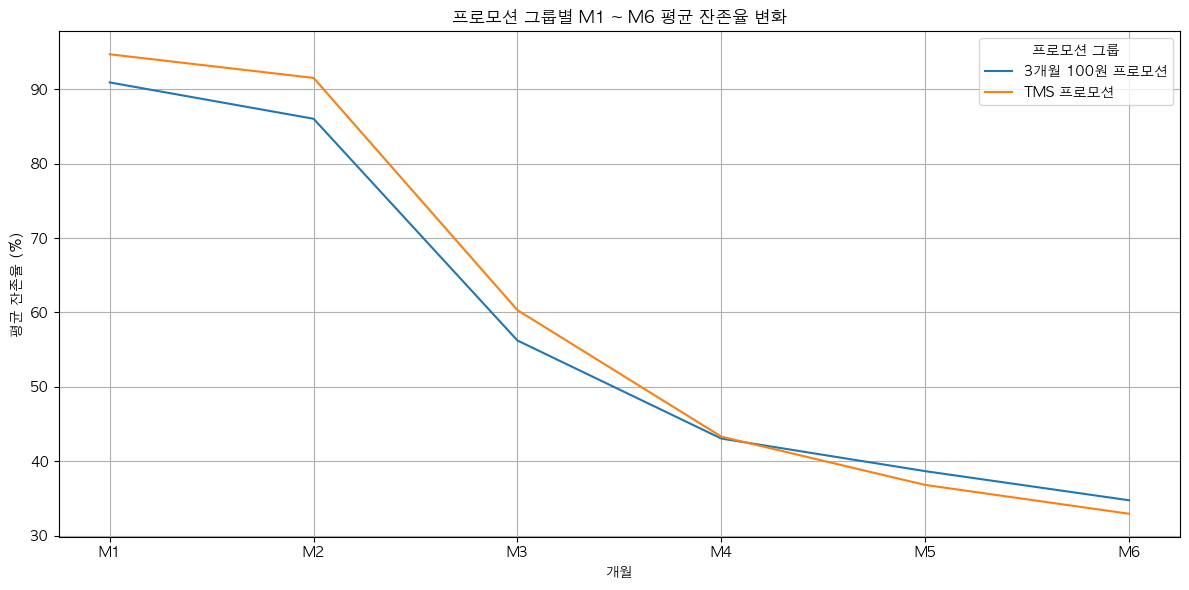

In [34]:
import matplotlib.pyplot as plt

# 1. YM 단위로 평균 잔존율 계산
ym_mean_retention = promo_retention_df.groupby(["YM", "PROMO_GRP_NM"])[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
print("YM 단위 평균 잔존율:")
print(ym_mean_retention)

# Reset index for easier manipulation
ym_mean_retention = ym_mean_retention.reset_index()

# 2. M1 ~ M6을 X축으로 설정하여 시각화
plt.figure(figsize=(12, 6))

# Plot each promotion group
for promo_grp in ym_mean_retention["PROMO_GRP_NM"].unique():
    # 프로모션 그룹별 평균 잔존율 추출
    promo_data = ym_mean_retention[ym_mean_retention["PROMO_GRP_NM"] == promo_grp]
    # M1 ~ M6 평균 잔존율 계산
    avg_retention = promo_data[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
    plt.plot(["M1", "M2", "M3", "M4", "M5", "M6"], avg_retention, label=promo_grp)

# 그래프 설정
plt.title("프로모션 그룹별 M1 ~ M6 평균 잔존율 변화")
plt.ylabel("평균 잔존율 (%)")
plt.xlabel("개월")
plt.legend(title="프로모션 그룹")
plt.grid(True)
plt.tight_layout()
plt.show()

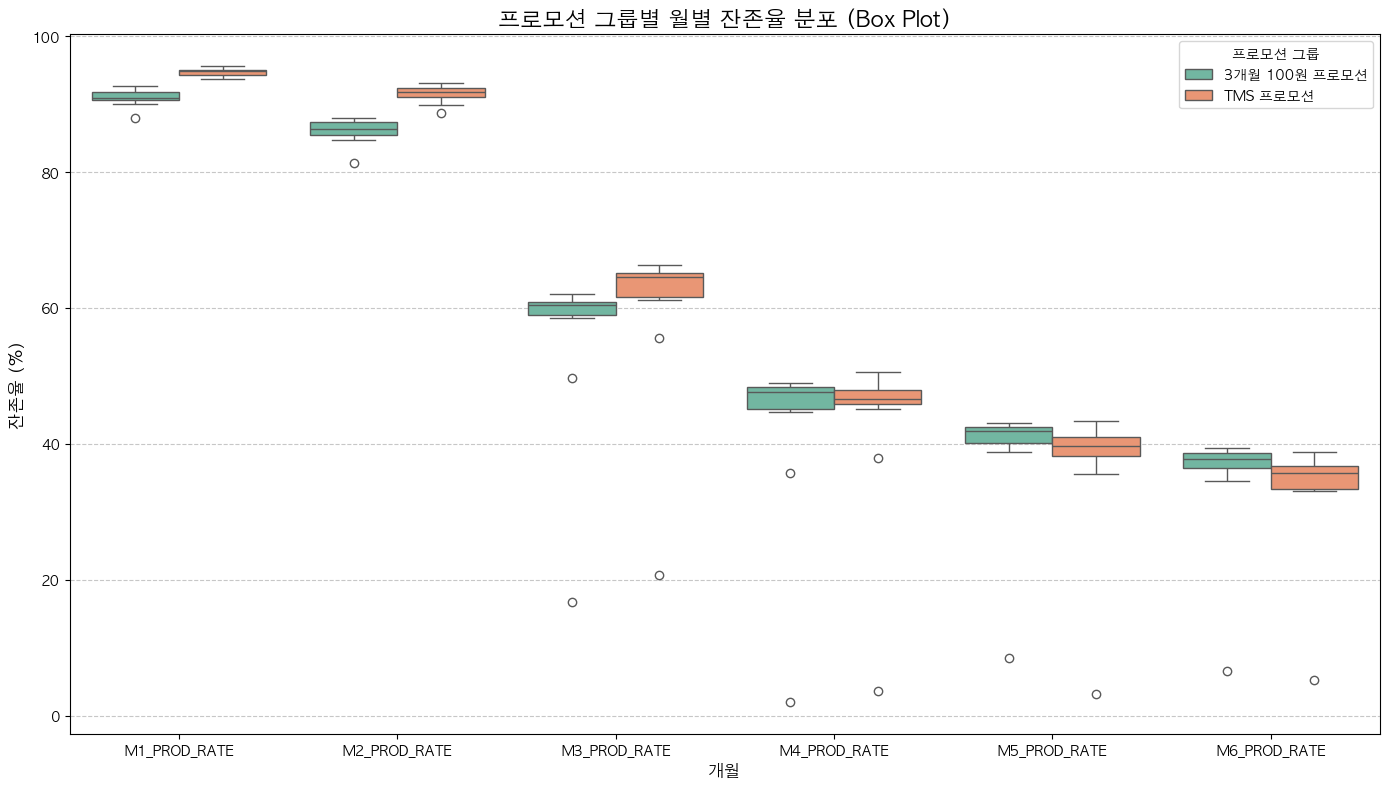

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 준비
# YM 단위 평균 잔존율 데이터에서 Box Plot을 그리기 위해 데이터 변환
boxplot_data = promo_retention_df.melt(
    id_vars=["YM", "PROMO_GRP_NM"], 
    value_vars=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"],
    var_name="Month", 
    value_name="Retention Rate"
)

# Month 열의 순서를 정렬
boxplot_data["Month"] = pd.Categorical(
    boxplot_data["Month"], 
    categories=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"], 
    ordered=True
)

# 2. Box Plot 그리기
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=boxplot_data, 
    x="Month", 
    y="Retention Rate", 
    hue="PROMO_GRP_NM", 
    palette="Set2"
)

# 그래프 설정
plt.title("프로모션 그룹별 월별 잔존율 분포 (Box Plot)", fontsize=16)
plt.xlabel("개월", fontsize=12)
plt.ylabel("잔존율 (%)", fontsize=12)
plt.legend(title="프로모션 그룹", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

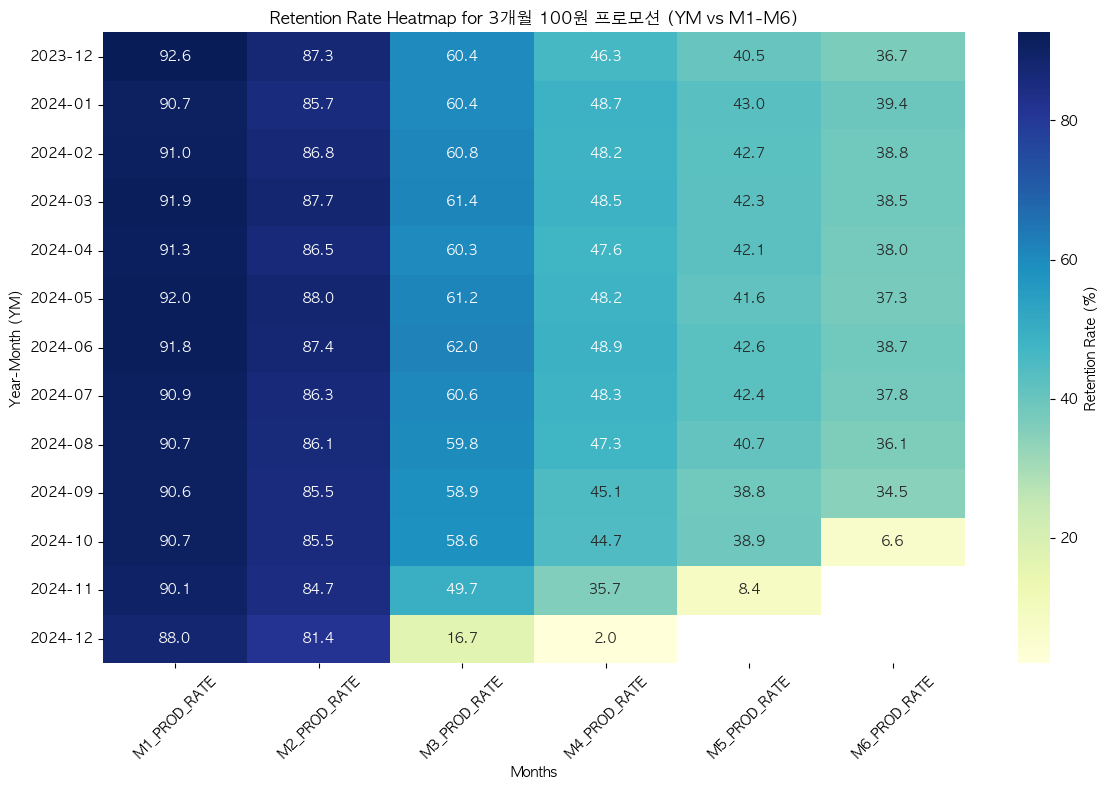

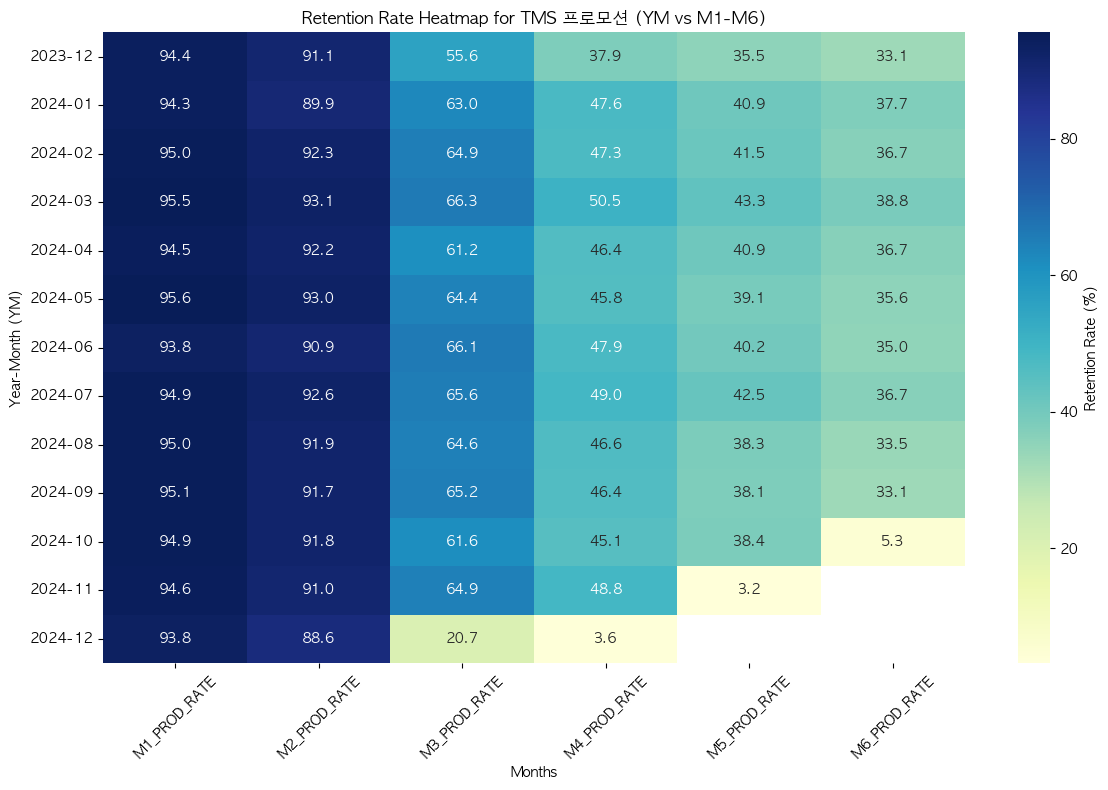

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비
# promo_retention_df에서 필요한 열만 선택
heatmap_data = promo_retention_df.melt(
    id_vars=["YM", "PROMO_GRP_NM"],  # PROMO_GRP_NM 추가
    value_vars=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"],
    var_name="Month", 
    value_name="Retention Rate"
)

# Month 열의 순서를 정렬
heatmap_data["Month"] = pd.Categorical(heatmap_data["Month"], categories=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"], ordered=True)

# 2. 프로모션 그룹별로 Heatmap 생성
promo_groups = heatmap_data["PROMO_GRP_NM"].unique()  # 프로모션 그룹 리스트

for promo_grp in promo_groups:
    # 특정 프로모션 그룹 데이터 필터링
    promo_data = heatmap_data[heatmap_data["PROMO_GRP_NM"] == promo_grp]
    
    # 피벗 테이블 생성 (YM을 Y축, Month를 X축으로 설정)
    heatmap_pivot = promo_data.pivot(index="YM", columns="Month", values="Retention Rate")
    
    # Heatmap 그리기
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Retention Rate (%)'})
    plt.title(f"Retention Rate Heatmap for {promo_grp} (YM vs M1-M6)")
    plt.xlabel("Months")
    plt.ylabel("Year-Month (YM)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

프로모션 그룹별 잔존율 표준편차:
               M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
PROMO_GRP_NM                                                            
3개월 100원 프로모션      1.139524      1.707967     12.263112     12.819582   
TMS 프로모션           0.574824      1.258441     12.233917     12.304736   

               M5_PROD_RATE  M6_PROD_RATE  
PROMO_GRP_NM                               
3개월 100원 프로모션      9.638072      9.454775  
TMS 프로모션          10.811318      9.372211  


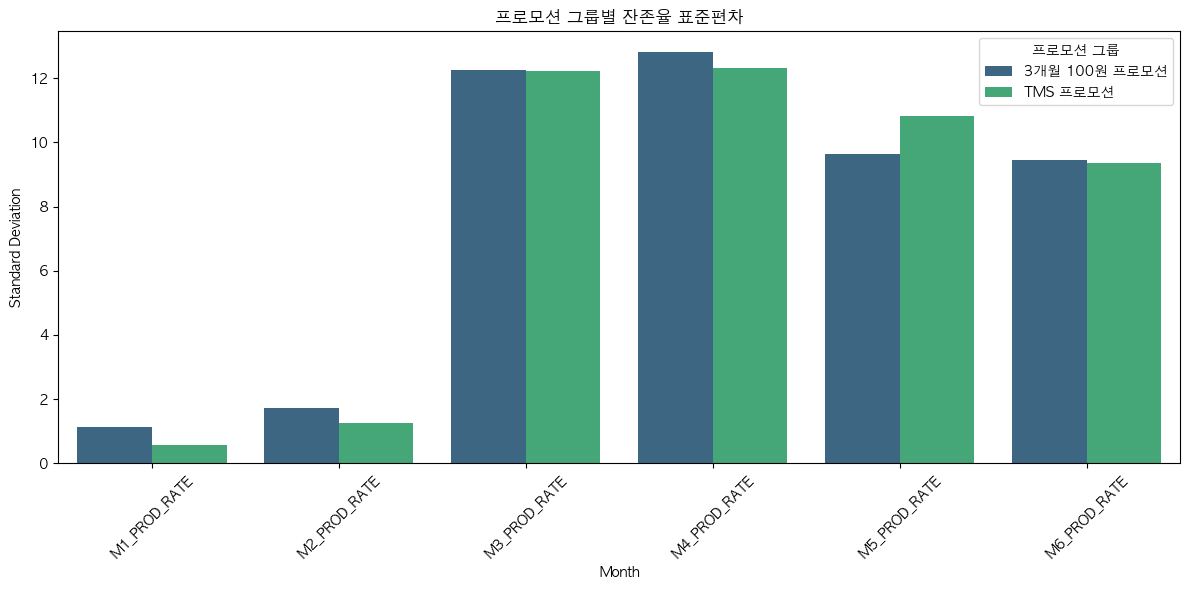

In [37]:
# 1. 프로모션 그룹별 잔존율 표준편차 계산
std_dev = promo_retention_df.groupby("PROMO_GRP_NM")[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].std()

# 표준편차 결과 출력
print("프로모션 그룹별 잔존율 표준편차:")
print(std_dev)

# 2. 시각화를 위해 데이터 변환
std_dev = std_dev.reset_index()  # 인덱스를 열로 변환
std_dev_melted = std_dev.melt(id_vars="PROMO_GRP_NM", var_name="Month", value_name="Standard Deviation")

# 3. 시각화: 프로모션 그룹별 잔존율 표준편차
plt.figure(figsize=(12, 6))
sns.barplot(data=std_dev_melted, x="Month", y="Standard Deviation", hue="PROMO_GRP_NM", palette="viridis")
plt.title("프로모션 그룹별 잔존율 표준편차")
plt.ylabel("Standard Deviation")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="프로모션 그룹")
plt.tight_layout()
plt.show()

In [38]:
# 2개월 100원 프로모션 데이터 쿼리
promo_2month_retention_query = '''
SELECT
    FST_DT AS YM
  , PROMO_GRP_NM
  , FST_PROD_CNT
  , IF(M1_PROD_CNT = 0, NULL, cast(M1_PROD_CNT  as double)/FST_PROD_CNT*100) AS M1_PROD_RATE
  , IF(M2_PROD_CNT = 0, NULL, cast(M2_PROD_CNT  as double)/FST_PROD_CNT*100) AS M2_PROD_RATE
  , IF(M3_PROD_CNT = 0, NULL, cast(M3_PROD_CNT  as double)/FST_PROD_CNT*100) AS M3_PROD_RATE
  , IF(M4_PROD_CNT = 0, NULL, cast(M4_PROD_CNT  as double)/FST_PROD_CNT*100) AS M4_PROD_RATE
  , IF(M5_PROD_CNT = 0, NULL, cast(M5_PROD_CNT  as double)/FST_PROD_CNT*100) AS M5_PROD_RATE
  , IF(M6_PROD_CNT = 0, NULL, cast(M6_PROD_CNT  as double)/FST_PROD_CNT*100) AS M6_PROD_RATE
  --, IF(M7_PROD_CNT = 0, NULL, cast(M7_PROD_CNT  as double)/FST_PROD_CNT*100) AS M7_PROD_RATE
  --, IF(M8_PROD_CNT = 0, NULL, cast(M8_PROD_CNT  as double)/FST_PROD_CNT*100) AS M8_PROD_RATE
  --, IF(M9_PROD_CNT = 0, NULL, cast(M9_PROD_CNT  as double)/FST_PROD_CNT*100) AS M9_PROD_RATE
  --, IF(M10_PROD_CNT= 0, NULL, cast(M10_PROD_CNT as double)/FST_PROD_CNT*100) AS M10_PROD_RATE
  --, IF(M11_PROD_CNT= 0, NULL, cast(M11_PROD_CNT as double)/FST_PROD_CNT*100) AS M11_PROD_RATE
  --, IF(M12_PROD_CNT= 0, NULL, cast(M12_PROD_CNT as double)/FST_PROD_CNT*100) AS M12_PROD_RATE
FROM (
    SELECT
        FST_DT
      , PROMO_GRP_NM
      , COUNT(DISTINCT FIRST_BUY_NO) AS FST_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 1, BUY_NO, NULL))  AS M1_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 2, BUY_NO, NULL))  AS M2_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 3, BUY_NO, NULL))  AS M3_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 4, BUY_NO, NULL))  AS M4_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 5, BUY_NO, NULL))  AS M5_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 6, BUY_NO, NULL))  AS M6_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 7, BUY_NO, NULL))  AS M7_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 8, BUY_NO, NULL))  AS M8_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 9, BUY_NO, NULL))  AS M9_PROD_CNT 
      , COUNT(DISTINCT IF(TERM = 10, BUY_NO, NULL)) AS M10_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 11, BUY_NO, NULL)) AS M11_PROD_CNT
      , COUNT(DISTINCT IF(TERM = 12, BUY_NO, NULL)) AS M12_PROD_CNT
    FROM (
        SELECT
            DATE_FORMAT(FST_DT, '%Y-%m') AS FST_DT
          , FIRST_BUY_NO
          , PROMO_GRP_NM
          , DT
          , BUY_NO
          , IF(NEW_TERM = LAG(NEW_TERM) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), NEW_TERM+1, NEW_TERM) AS TERM
--          , DATE_DIFF('MONTH', DATE(DATE_FORMAT(FST_DT, '%Y-%m-01')), DATE(DATE(DATE_FORMAT(CURRENT_DATE, '%Y-%m-01')))) AS TEMP
        FROM (
            SELECT 
                FST_DT
              , FIRST_BUY_NO
              , PROMO_GRP_NM
              , MEMBER_KEY
              , DT
              , BUY_NO
              , CASE
                    WHEN (BF_TERM + 1) = TERM THEN TERM
                    WHEN (BF_TERM + 1) <> TERM AND (MONTH(BF_DT) = MONTH(DT)) THEN (TERM + 1)
                    ELSE TERM
                END AS NEW_TERM
            FROM (
                SELECT
                    FST_DT
                  , FIRST_BUY_NO
                  , PROMO_GRP_NM
                  , MEMBER_KEY
                  , DT
                  , BUY_NO
                  , TERM
                  , COALESCE(LAG(DT)     OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FST_DT) AS BF_DT
                  , COALESCE(LAG(BUY_NO) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FIRST_BUY_NO) AS BF_BUY_NO
                  , COALESCE(LAG(TERM)   OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), 0) AS BF_TERM
                FROM (
                    SELECT F1.DT AS FST_DT
                         , F1.FIRST_BUY_NO
                         , F1.PROMO_GRP_NM
                         , F1.MEMBER_KEY
                         , F2.BUY_NO
                         , F2.DT
                         , DATE_DIFF('MONTH', F1.DT, F2.DT) AS TERM
                    FROM (
                        SELECT T1.DT
                             , T1.FIRST_BUY_NO
                             , T1.BUY_NO
                             , T1.USER_MKEY AS MEMBER_KEY
                             , T5.PROMO_DC_GRP
                             , T3.PROMO_GRP_CD
                             , T6.PROMO_GRP_NM
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD T2  ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO T4 ON (T1.PROD_ID = T4.PROD_ID)
                        JOIN(
                            SELECT PROMO_DC_GRP_CD
                                 , PROMO_DC_GRP_NM
                                 , CASE
                                    WHEN PROMO_DC_GRP_CD IN (2,3,4) THEN '1개월 0원 + 장기할인'
                                    WHEN PROMO_DC_GRP_CD IN (5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,83,86,87,88,91,93,94,98,109) THEN '1개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (95,101,102) THEN '1개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (28,29,30,31,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) THEN '2개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (33,103) THEN '2개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,81,82,84,85,89,90,92,96,97,99,100,104,110,107,108) THEN '장기할인(3개월이상)'
                                    ELSE PROMO_DC_GRP_NM
                                   END AS PROMO_DC_GRP
                            FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO_DC_GRP
                        ) T5 ON T3.PROMO_DC_GRP_CD = T5.PROMO_DC_GRP_CD
                        left join hadoop_kent.melon_ma_stat_production.d_promo_grp t6 on t3.promo_grp_cd = t6.promo_grp_cd
                        WHERE T1.LOG_DATE BETWEEN '20231201' AND '20241231'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') BETWEEN '20231201' AND '20241231'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD = 1100 --IN (1100, 1200, 1201, 1205, 1203,1206,1207) /*신규 로직에서 1206 제외*/ 
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND PROD_PRT_CD = 20000  /*클럽 상품*/
                          AND T5.PROMO_DC_GRP = '2개월 100원'
                          AND T3.PROMO_GRP_CD <> 49
                        GROUP BY 1, 2, 3, 4,5, 6, 7

                    ) F1
                    LEFT OUTER JOIN (
                        SELECT DT
                             , FIRST_BUY_NO
                             , BUY_NO
                             , USER_MKEY AS MEMBER_KEY
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT  T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD               T2 ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO              T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO     T4 ON (T1.PROD_ID = T4.PROD_ID)
                        WHERE T1.LOG_DATE >= '20231201'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') >= '20231201'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1202) /*자결*/
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND SELL_TYPE_CODE = 'ON1300'
                        GROUP BY 1, 2, 3, 4
                    ) F2 ON (F1.FIRST_BUY_NO = F2.FIRST_BUY_NO AND F1.MEMBER_KEY = F2.MEMBER_KEY AND F2.BUY_NO > F1.BUY_NO)
                ) F3
            ) DF1
        ) DF2
    ) DF3
--    WHERE TERM < TEMP
    GROUP BY 1,2
)
WHERE FST_PROD_CNT > 1000
ORDER BY 1,2
'''

cur.execute(promo_2month_retention_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

promo_2month_retention_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
promo_2month_retention_df.head()

,YM,PROMO_GRP_NM,FST_PROD_CNT,M1_PROD_RATE,M2_PROD_RATE,M3_PROD_RATE,M4_PROD_RATE,M5_PROD_RATE,M6_PROD_RATE
0,2023-12,TMS 프로모션,4179,93.802345,40.392438,22.349844,17.564011,15.266810,13.400335
1,2023-12,두달 100원 프로모션,37508,89.047670,40.146102,25.733177,20.579610,17.865522,15.985923
2,2024-01,TMS 프로모션,3762,93.965976,52.737905,33.040936,26.794258,23.684211,21.132376
3,2024-01,두달 100원 프로모션,40196,88.640661,47.763459,32.480844,26.776296,23.611802,21.173749
4,2024-02,TMS 프로모션,3237,94.192153,51.282051,34.074761,27.587272,23.571208,21.099784


In [39]:

# 1. 평균 잔존율 비교
mean_retention = promo_2month_retention_df.groupby("PROMO_GRP_NM")[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
print("평균 잔존율 비교:")
print(mean_retention)

# 2. M3 이후 잔존율 감소율 계산
promo_2month_retention_df["M2_to_M6_Drop"] = promo_2month_retention_df["M2_PROD_RATE"] - promo_2month_retention_df["M6_PROD_RATE"]
drop_rate = promo_2month_retention_df.groupby("PROMO_GRP_NM")["M2_to_M6_Drop"].mean()
print("\nM2 이후 잔존율 감소율:")
print(drop_rate)


평균 잔존율 비교:
              M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
PROMO_GRP_NM                                                           
TMS 프로모션         94.149657     46.761265     27.758550     20.667856   
두달 100원 프로모션     89.103995     42.687723     27.637758     21.369463   

              M5_PROD_RATE  M6_PROD_RATE  
PROMO_GRP_NM                              
TMS 프로모션         17.892303     15.976014  
두달 100원 프로모션     18.850247     16.916943  

M2 이후 잔존율 감소율:
PROMO_GRP_NM
TMS 프로모션        32.027010
두달 100원 프로모션    27.274787
Name: M2_to_M6_Drop, dtype: float64


YM 단위 평균 잔존율:
                      M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
YM      PROMO_GRP_NM                                                           
2023-12 TMS 프로모션         93.802345     40.392438     22.349844     17.564011   
        두달 100원 프로모션     89.047670     40.146102     25.733177     20.579610   
2024-01 TMS 프로모션         93.965976     52.737905     33.040936     26.794258   
        두달 100원 프로모션     88.640661     47.763459     32.480844     26.776296   
2024-02 TMS 프로모션         94.192153     51.282051     34.074761     27.587272   
        두달 100원 프로모션     88.895034     47.618909     33.384759     27.816266   
2024-03 TMS 프로모션         93.891484     51.311534     33.560905     26.518146   
        두달 100원 프로모션     89.078034     47.052825     32.100269     26.500496   
2024-04 TMS 프로모션         94.929577     47.002012     29.698189     23.380282   
        두달 100원 프로모션     89.762235     45.974896     31.597369     25.985155   
2024-05 TMS 프로모션         9

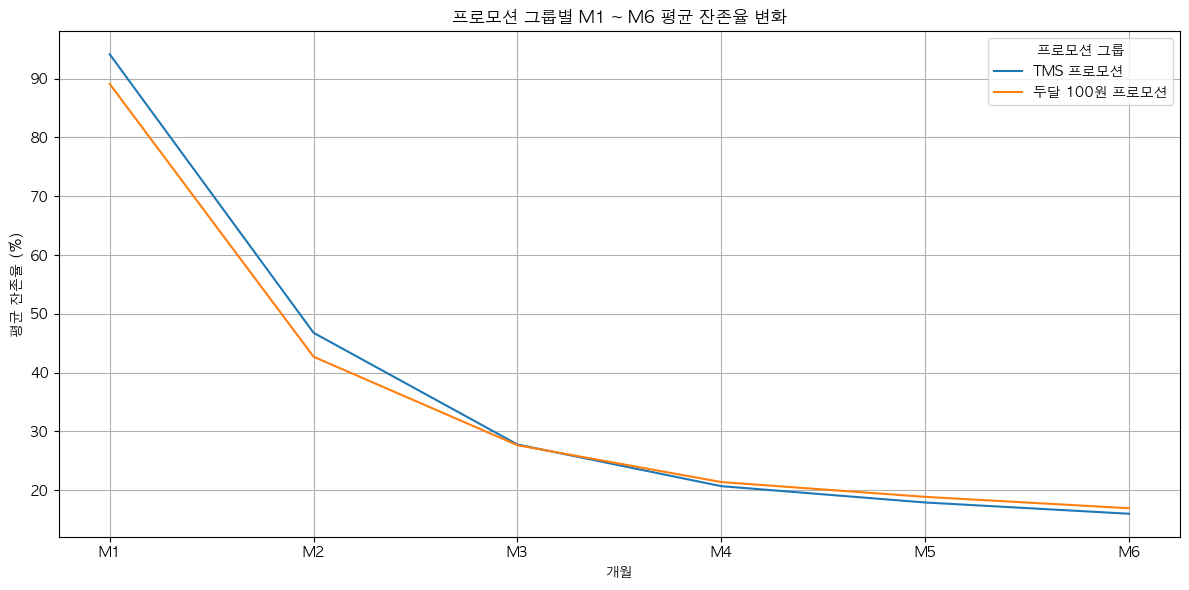

In [40]:
import matplotlib.pyplot as plt

# 1. YM 단위로 평균 잔존율 계산
ym_mean_retention = promo_2month_retention_df.groupby(["YM", "PROMO_GRP_NM"])[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
print("YM 단위 평균 잔존율:")
print(ym_mean_retention)

# Reset index for easier manipulation
ym_mean_retention = ym_mean_retention.reset_index()

# 2. M1 ~ M6을 X축으로 설정하여 시각화
plt.figure(figsize=(12, 6))

# Plot each promotion group
for promo_grp in ym_mean_retention["PROMO_GRP_NM"].unique():
    # 프로모션 그룹별 평균 잔존율 추출
    promo_data = ym_mean_retention[ym_mean_retention["PROMO_GRP_NM"] == promo_grp]
    # M1 ~ M6 평균 잔존율 계산
    avg_retention = promo_data[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].mean()
    plt.plot(["M1", "M2", "M3", "M4", "M5", "M6"], avg_retention, label=promo_grp)

# 그래프 설정
plt.title("프로모션 그룹별 M1 ~ M6 평균 잔존율 변화")
plt.ylabel("평균 잔존율 (%)")
plt.xlabel("개월")
plt.legend(title="프로모션 그룹")
plt.grid(True)
plt.tight_layout()
plt.show()

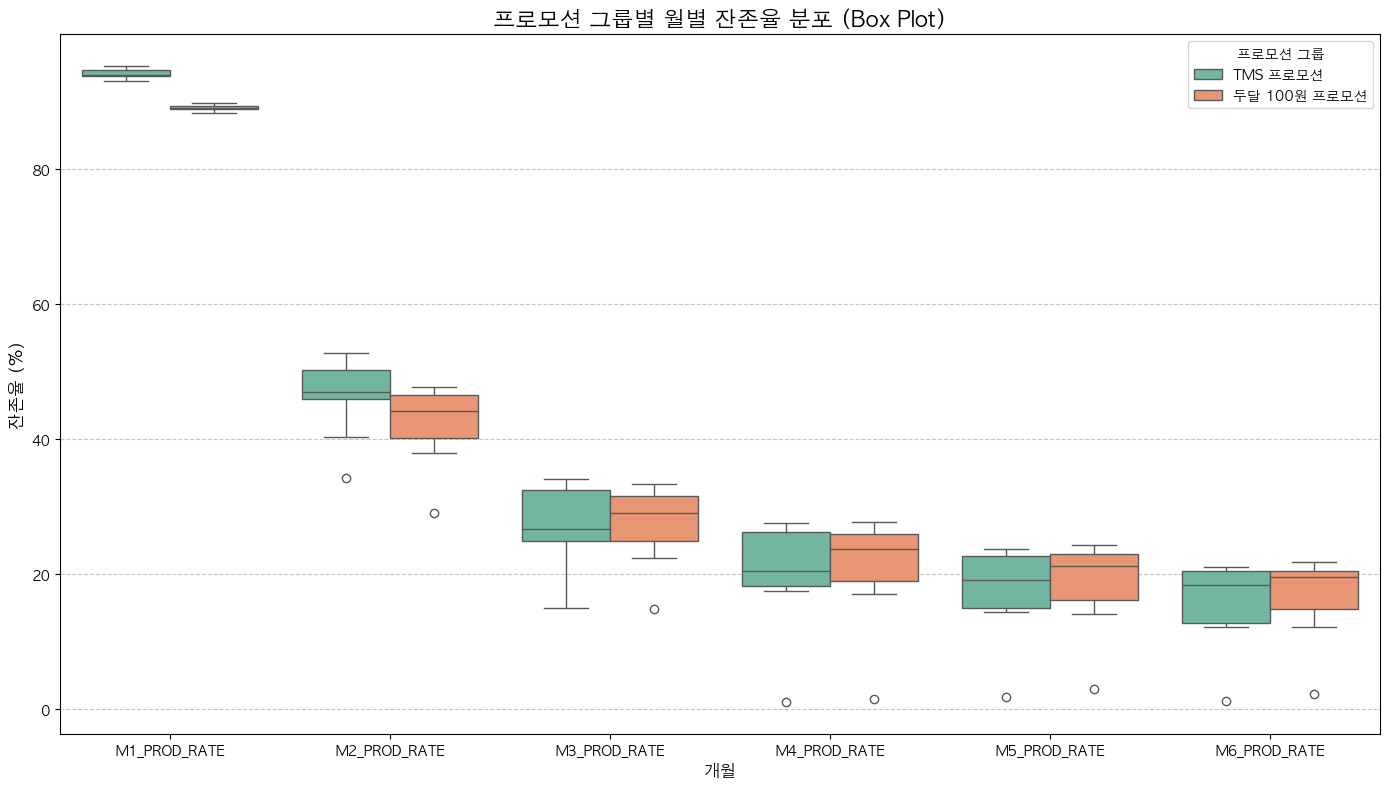

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 준비
# YM 단위 평균 잔존율 데이터에서 Box Plot을 그리기 위해 데이터 변환
boxplot_data = promo_2month_retention_df.melt(
    id_vars=["YM", "PROMO_GRP_NM"], 
    value_vars=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"],
    var_name="Month", 
    value_name="Retention Rate"
)

# Month 열의 순서를 정렬
boxplot_data["Month"] = pd.Categorical(
    boxplot_data["Month"], 
    categories=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"], 
    ordered=True
)

# 2. Box Plot 그리기
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=boxplot_data, 
    x="Month", 
    y="Retention Rate", 
    hue="PROMO_GRP_NM", 
    palette="Set2"
)

# 그래프 설정
plt.title("프로모션 그룹별 월별 잔존율 분포 (Box Plot)", fontsize=16)
plt.xlabel("개월", fontsize=12)
plt.ylabel("잔존율 (%)", fontsize=12)
plt.legend(title="프로모션 그룹", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

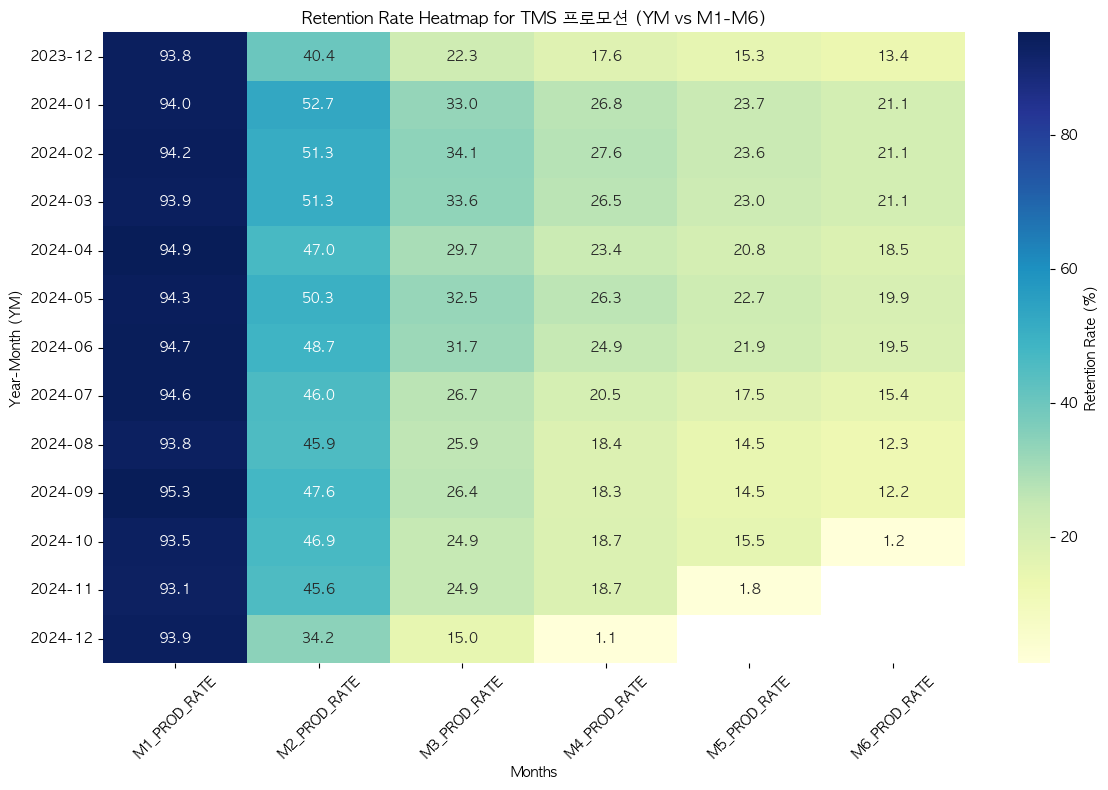

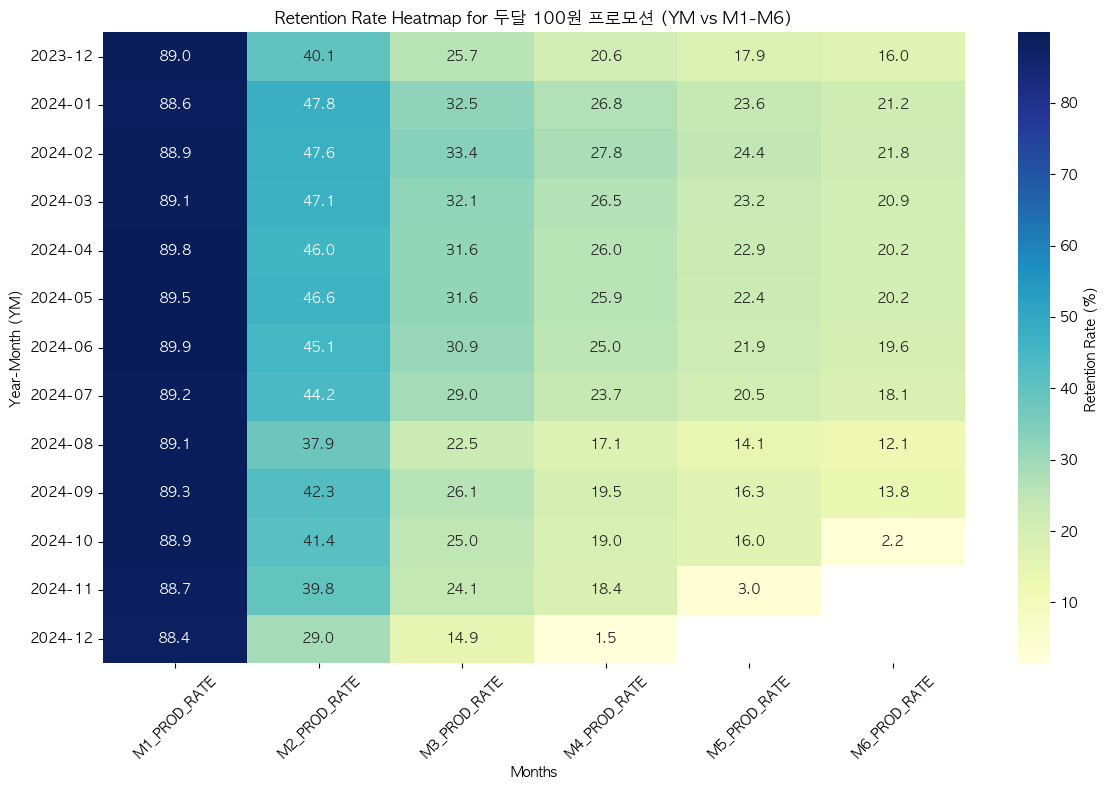

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 준비
# promo_2month_retention_df에서 필요한 열만 선택
heatmap_data = promo_2month_retention_df.melt(
    id_vars=["YM", "PROMO_GRP_NM"],  # PROMO_GRP_NM 추가
    value_vars=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"],
    var_name="Month", 
    value_name="Retention Rate"
)

# Month 열의 순서를 정렬
heatmap_data["Month"] = pd.Categorical(heatmap_data["Month"], categories=["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"], ordered=True)

# 2. 프로모션 그룹별로 Heatmap 생성
promo_groups = heatmap_data["PROMO_GRP_NM"].unique()  # 프로모션 그룹 리스트

for promo_grp in promo_groups:
    # 특정 프로모션 그룹 데이터 필터링
    promo_data = heatmap_data[heatmap_data["PROMO_GRP_NM"] == promo_grp]
    
    # 피벗 테이블 생성 (YM을 Y축, Month를 X축으로 설정)
    heatmap_pivot = promo_data.pivot(index="YM", columns="Month", values="Retention Rate")
    
    # Heatmap 그리기
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_pivot, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Retention Rate (%)'})
    plt.title(f"Retention Rate Heatmap for {promo_grp} (YM vs M1-M6)")
    plt.xlabel("Months")
    plt.ylabel("Year-Month (YM)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

프로모션 그룹별 잔존율 표준편차:
              M1_PROD_RATE  M2_PROD_RATE  M3_PROD_RATE  M4_PROD_RATE  \
PROMO_GRP_NM                                                           
TMS 프로모션           0.61056      4.943542      5.460911      6.999612   
두달 100원 프로모션       0.43409      5.235541      5.289010      7.010697   

              M5_PROD_RATE  M6_PROD_RATE  
PROMO_GRP_NM                              
TMS 프로모션          6.286924      6.034938  
두달 100원 프로모션      6.047251      5.803693  


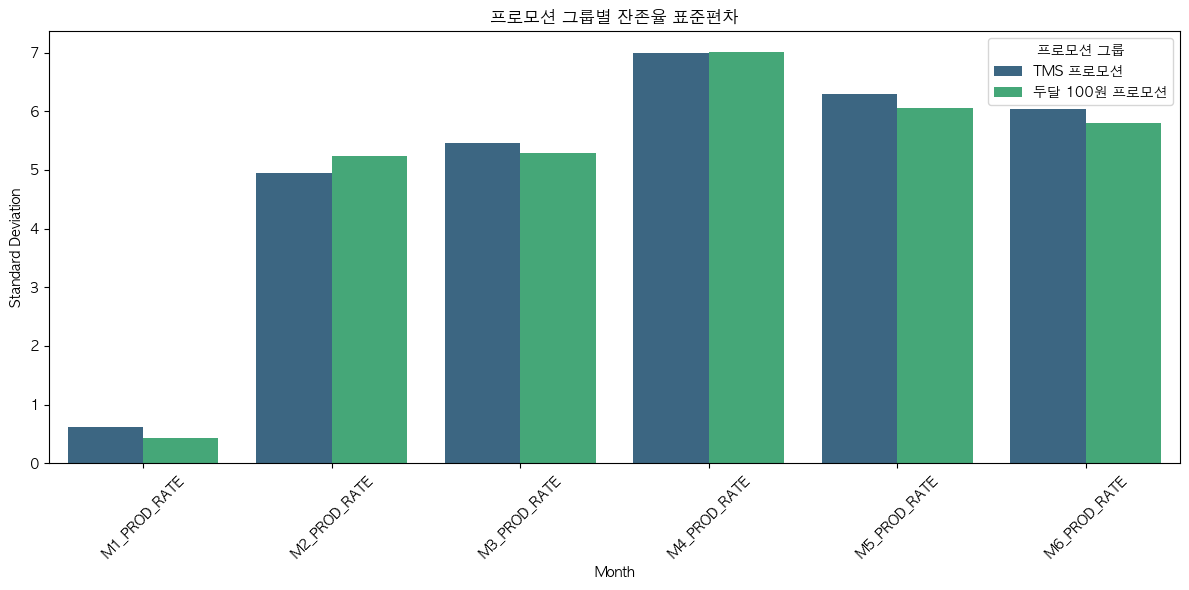

In [43]:
# 1. 프로모션 그룹별 잔존율 표준편차 계산
std_dev = promo_2month_retention_df.groupby("PROMO_GRP_NM")[["M1_PROD_RATE", "M2_PROD_RATE", "M3_PROD_RATE", "M4_PROD_RATE", "M5_PROD_RATE", "M6_PROD_RATE"]].std()

# 표준편차 결과 출력
print("프로모션 그룹별 잔존율 표준편차:")
print(std_dev)

# 2. 시각화를 위해 데이터 변환
std_dev = std_dev.reset_index()  # 인덱스를 열로 변환
std_dev_melted = std_dev.melt(id_vars="PROMO_GRP_NM", var_name="Month", value_name="Standard Deviation")

# 3. 시각화: 프로모션 그룹별 잔존율 표준편차
plt.figure(figsize=(12, 6))
sns.barplot(data=std_dev_melted, x="Month", y="Standard Deviation", hue="PROMO_GRP_NM", palette="viridis")
plt.title("프로모션 그룹별 잔존율 표준편차")
plt.ylabel("Standard Deviation")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="프로모션 그룹")
plt.tight_layout()
plt.show()

In [57]:
## 프로모션 그룹 및 할인율 그룹에 따른 정상가 전환 상품 비율
normal_price_prod_query = '''
    WITH term_data as(
        SELECT
            DATE_FORMAT(FST_DT, '%Y-%m') AS FST_DT
          , FIRST_BUY_NO
          , PROMO_GRP_NM
          , PROMO_DC_GRP
          , DT
          , BUY_NO
          , normal_price_yn 
          , IF(NEW_TERM = LAG(NEW_TERM) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), NEW_TERM+1, NEW_TERM) AS TERM
        FROM (
            SELECT 
                FST_DT
              , FIRST_BUY_NO
              , PROMO_GRP_NM
              , PROMO_DC_GRP
              , MEMBER_KEY
              , DT
              , BUY_NO
              , normal_price_yn
              , CASE
                    WHEN (BF_TERM + 1) = TERM THEN TERM
                    WHEN (BF_TERM + 1) <> TERM AND (MONTH(BF_DT) = MONTH(DT)) THEN (TERM + 1)
                    ELSE TERM
                END AS NEW_TERM
            FROM (
                SELECT
                    FST_DT
                  , FIRST_BUY_NO
                  , PROMO_GRP_NM
                  , PROMO_DC_GRP
                  , MEMBER_KEY
                  , DT
                  , BUY_NO
                  , normal_price_yn
                  , TERM
                  , COALESCE(LAG(DT)     OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FST_DT) AS BF_DT
                  , COALESCE(LAG(BUY_NO) OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), FIRST_BUY_NO) AS BF_BUY_NO
                  , COALESCE(LAG(TERM)   OVER (PARTITION BY FST_DT, FIRST_BUY_NO, MEMBER_KEY ORDER BY DT), 0) AS BF_TERM
                FROM (
                    SELECT F1.DT AS FST_DT
                         , F1.FIRST_BUY_NO
                         , F1.PROMO_GRP_NM
                         , F1.PROMO_DC_GRP
                         , F1.MEMBER_KEY
                         , F2.BUY_NO
                         , F2.normal_price_yn
                         , F2.DT
                         , DATE_DIFF('MONTH', F1.DT, F2.DT) AS TERM
                    FROM (
                        SELECT T1.DT
                             , T1.FIRST_BUY_NO
                             , T1.BUY_NO
                             , T1.USER_MKEY AS MEMBER_KEY
                             , T5.PROMO_DC_GRP
                             , T3.PROMO_GRP_CD
                             , T6.PROMO_GRP_NM
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD T2  ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO T4 ON (T1.PROD_ID = T4.PROD_ID)
                        JOIN(
                            SELECT PROMO_DC_GRP_CD
                                 , PROMO_DC_GRP_NM
                                 , CASE
                                    WHEN PROMO_DC_GRP_CD IN (2,3,4) THEN '1개월 0원 + 장기할인'
                                    WHEN PROMO_DC_GRP_CD IN (5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,83,86,87,88,91,93,94,98,109) THEN '1개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (95,101,102) THEN '1개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (28,29,30,31,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51) THEN '2개월 할인'
                                    WHEN PROMO_DC_GRP_CD IN (33,103) THEN '2개월 100원 + 할인'
                                    WHEN PROMO_DC_GRP_CD IN (54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,81,82,84,85,89,90,92,96,97,99,100,104,110,107,108) THEN '장기할인(3개월이상)'
                                    ELSE PROMO_DC_GRP_NM
                                   END AS PROMO_DC_GRP
                            FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO_DC_GRP
                        ) T5 ON T3.PROMO_DC_GRP_CD = T5.PROMO_DC_GRP_CD
                        left join hadoop_kent.melon_ma_stat_production.d_promo_grp t6 on t3.promo_grp_cd = t6.promo_grp_cd
                        WHERE T1.LOG_DATE BETWEEN '20231201' AND '20241231'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') BETWEEN '20231201' AND '20241231'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD = 1100 --IN (1100, 1200, 1201, 1205, 1203,1206,1207) /*신규 로직에서 1206 제외*/ 
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND PROD_PRT_CD = 20000  /*클럽 상품*/
                          AND T3.PROMO_GRP_CD NOT IN (49,9999,41,68)
                          AND T5.PROMO_DC_GRP IN ('2개월 100원','3개월 100원','1개월 100원 + 할인','2개월 0원')
                        GROUP BY 1, 2, 3, 4,5, 6, 7

                    ) F1
                    LEFT OUTER JOIN (
                        SELECT DT
                             , FIRST_BUY_NO
                             , BUY_NO
                             , USER_MKEY AS MEMBER_KEY
                             , t2.sale_amt
                             , t1.prim_bill_mthd_bill_amt
                             , if(t1.prim_bill_mthd_bill_amt = t2.sale_amt,'Y','N') as normal_price_yn
                        FROM HADOOP_KENT.MELON_MA_STAT_PRODUCTION.F_PROD_USER_FXMT_DT  T1
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROD               T2 ON (T1.PROD_ID = T2.PROD_ID)
                        JOIN HADOOP_KENT.MELON_MA_STAT_PRODUCTION.D_PROMO              T3 ON (T1.PROMO_ID = T3.PROMO_ID)
                        JOIN HADOOP_KENT.MELON_ODS_COMMERCE_PRODUCTION.CPT_PROD_TB_RO     T4 ON (T1.PROD_ID = T4.PROD_ID)
                        WHERE T1.LOG_DATE >= '20231201'
                          AND DATE_FORMAT(T1.DT, '%Y%m%d') >= '20231201'
                          AND PF_YN = 1
                          AND T2.PROD_ATTR_CD NOT IN (10040, 10050)
                          AND T1.PROD_JOIN_PRT_CD IN (1202) /*자결*/
                          AND T2.PROD_SELL_PRT_CD IN (60000) /*B2C*/
                          AND SELL_TYPE_CODE = 'ON1300'
                        GROUP BY 1, 2, 3, 4, 5, 6
                    ) F2 ON (F1.FIRST_BUY_NO = F2.FIRST_BUY_NO AND F1.MEMBER_KEY = F2.MEMBER_KEY AND F2.BUY_NO > F1.BUY_NO)
                ) F3
            ) DF1
        ) DF2
)

SELECT F1.PROMO_GRP_NM
     , F1.PROMO_DC_GRP
     , F1.FST_DT
     , F1.FST_PROD_CNT
     , F1.fst_normal_price_term
     , F2.prod_cnt as normal_termm_prod_cnt
     , F3.prod_cnt as normal_term_1m_prod_cnt
     , cast(F2.prod_cnt as double)/cast(f1.fst_prod_cnt as double)*100 as normal_term_prod_ratio
     , cast(F3.prod_cnt as double)/cast(f1.fst_prod_cnt as double)*100 as normal_term_1m_prod_ratio
FROM(
    SELECT
        PROMO_GRP_NM
      , PROMO_DC_GRP
      , FST_DT
      , COUNT(DISTINCT FIRST_BUY_NO) AS FST_PROD_CNT
      , min(if(normal_price_yn = 'Y',term)) as fst_normal_price_term
    FROM term_data
    GROUP BY 1,2,3
    HAVING(COUNT(DISTINCT FIRST_BUY_NO) > 1000)
    ORDER BY 1,2,3
) F1
LEFT JOIN(
    SELECT 
        PROMO_GRP_NM
      , PROMO_DC_GRP
      , FST_DT
      , term
      , count(distinct buy_no) as prod_cnt
    FROM term_data
    GROUP BY 1,2,3,4
) F2 ON F1.PROMO_GRP_NM = F2.PROMO_GRP_NM AND F1.PROMO_DC_GRP = F2.PROMO_DC_GRP AND F1.FST_DT = F2.FST_DT AND F2.TERM = F1.fst_normal_price_term
LEFT JOIN(
    SELECT 
        PROMO_GRP_NM
      , PROMO_DC_GRP
      , FST_DT
      , term
      , count(distinct buy_no) as prod_cnt
    FROM term_data
    GROUP BY 1,2,3,4
) F3 ON F1.PROMO_GRP_NM = F3.PROMO_GRP_NM AND F1.PROMO_DC_GRP = F3.PROMO_DC_GRP AND F1.FST_DT = F3.FST_DT AND F3.TERM = F1.fst_normal_price_term + 1
order by 2,1,3
'''

cur.execute(normal_price_prod_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

normal_price_prod_df = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
normal_price_prod_df.head()

,promo_grp_nm,promo_dc_grp,fst_dt,fst_prod_cnt,fst_normal_price_term,normal_termm_prod_cnt,normal_term_1m_prod_cnt,normal_term_prod_ratio,normal_term_1m_prod_ratio
0,N개월 N원 프로모션,1개월 100원 + 할인,2023-12,45543,3,13709,11143,30.101223,24.466987
1,N개월 N원 프로모션,1개월 100원 + 할인,2024-01,85031,3,26859,21703,31.587303,25.523633
2,N개월 N원 프로모션,1개월 100원 + 할인,2024-02,80107,3,25687,20541,32.065862,25.641954
3,N개월 N원 프로모션,1개월 100원 + 할인,2024-03,76402,3,24909,20069,32.602550,26.267637
4,N개월 N원 프로모션,1개월 100원 + 할인,2024-04,67975,3,22473,17780,33.060684,26.156675


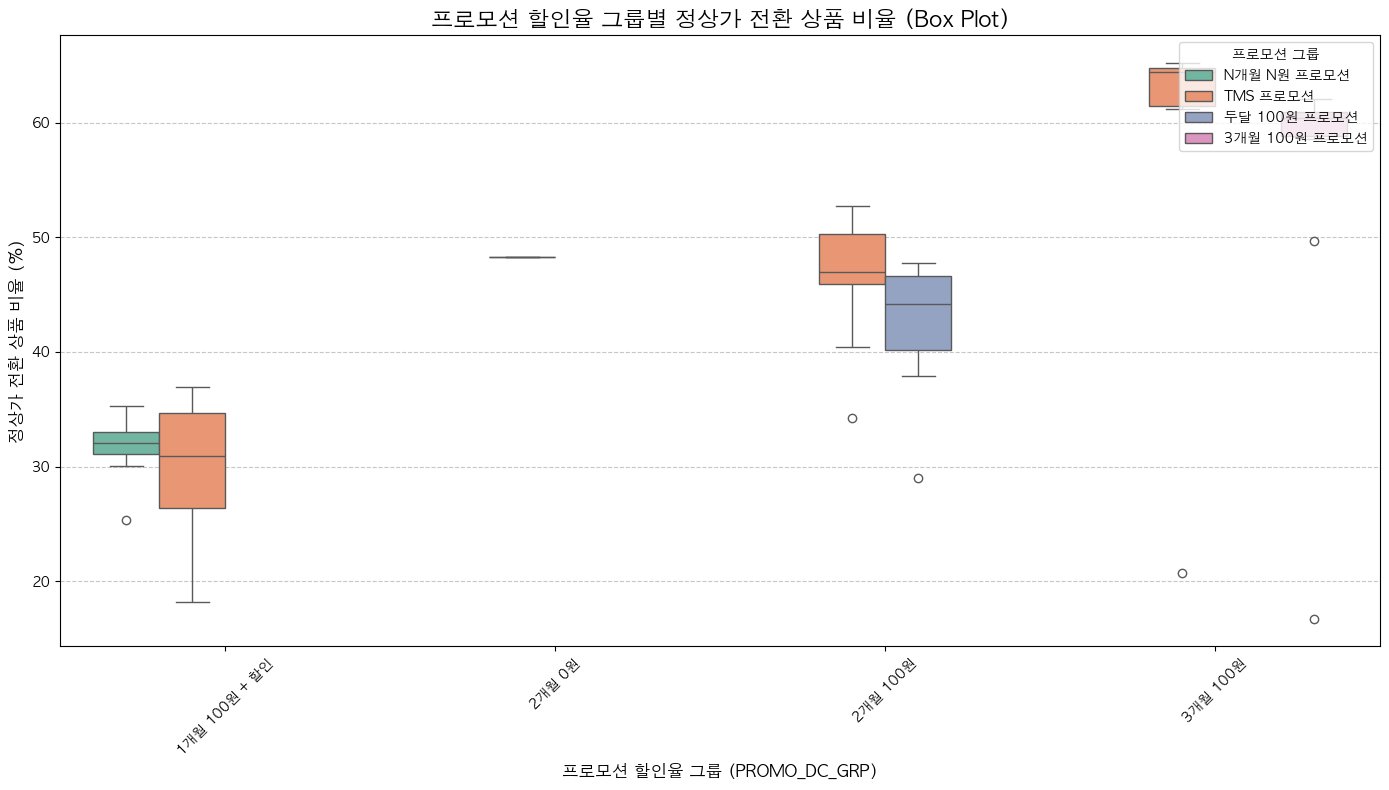

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Box Plot 그리기
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=normal_price_prod_df,
    x="promo_dc_grp",
    y="normal_term_prod_ratio",
    hue="promo_grp_nm",  # PROMO_GRP_NM 기준으로 나눔
    palette="Set2"  # 색상 팔레트 설정
)

# 2. 그래프 설정
plt.title("프로모션 할인율 그룹별 정상가 전환 상품 비율 (Box Plot)", fontsize=16)
plt.xlabel("프로모션 할인율 그룹 (PROMO_DC_GRP)", fontsize=12)
plt.ylabel("정상가 전환 상품 비율 (%)", fontsize=12)
plt.xticks(rotation=45)  # X축 레이블 회전
plt.legend(title="프로모션 그룹", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y축 격자 추가
plt.tight_layout()
plt.show()

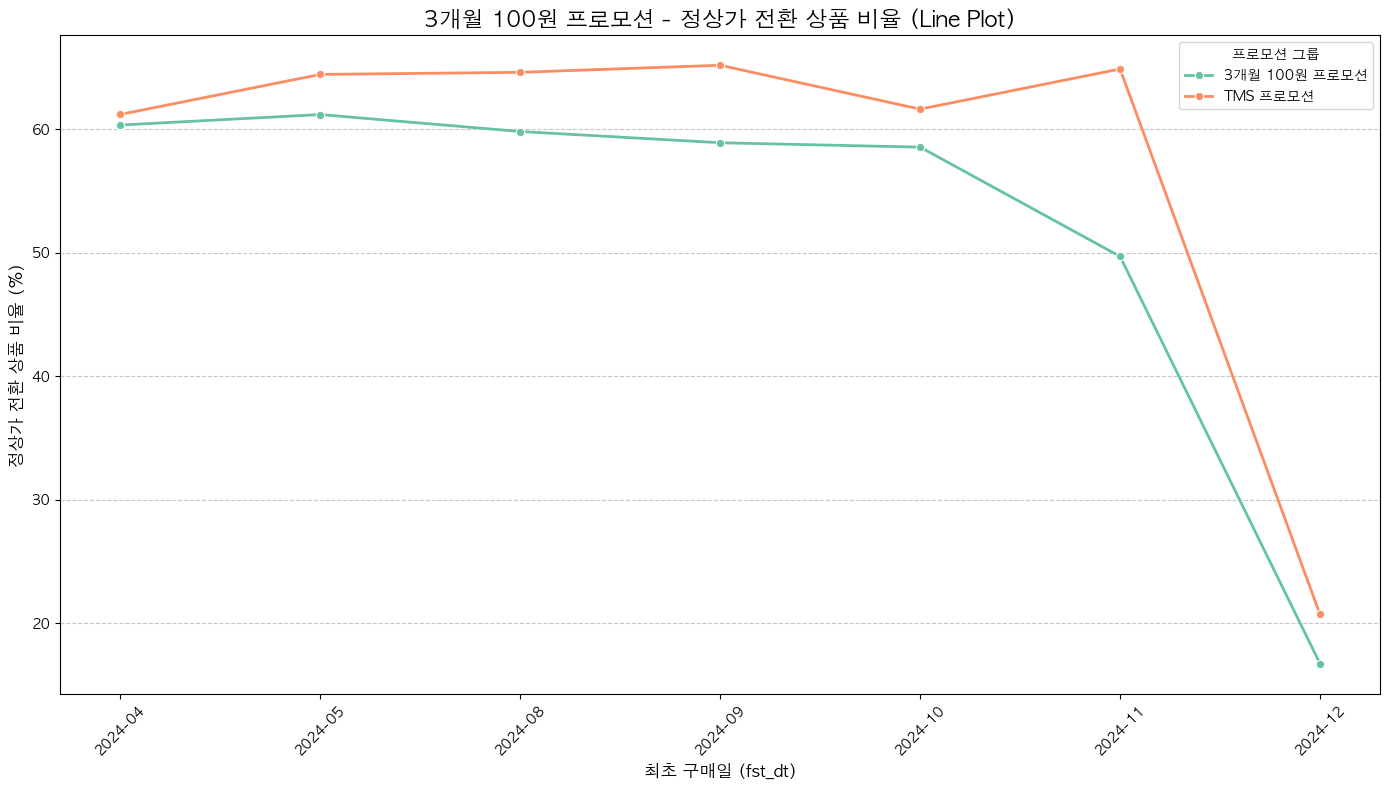

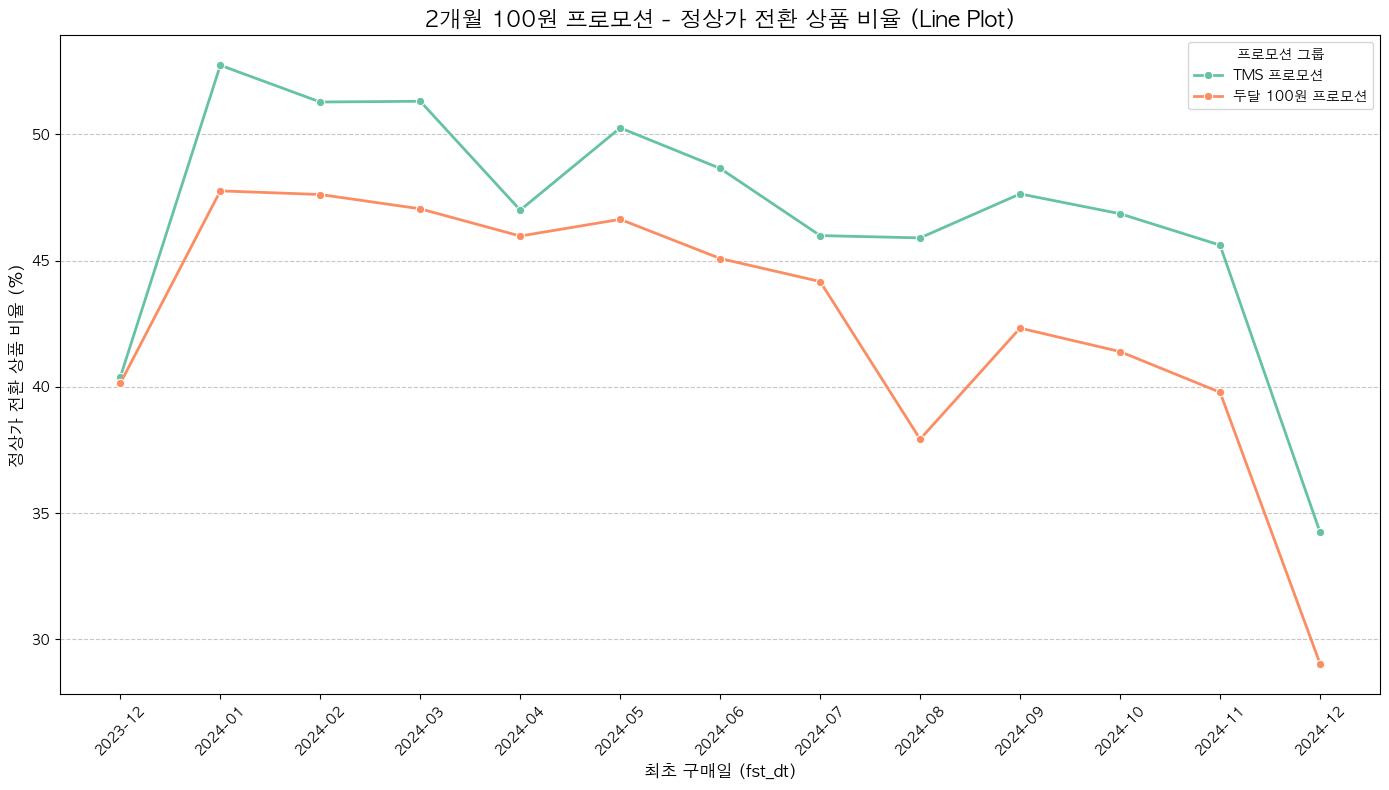

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 필터링
filtered_data = normal_price_prod_df[normal_price_prod_df["promo_dc_grp"] == "3개월 100원"]

# 1. TMS 프로모션이 포함된 년월 필터링
tms_months = filtered_data[filtered_data["promo_grp_nm"] == "TMS 프로모션"]["fst_dt"].unique()
filtered_data = filtered_data[filtered_data["fst_dt"].isin(tms_months)]


# 2. Line Plot 그리기
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=filtered_data,
    x="fst_dt",  # X축: 최초 구매일
    y="normal_term_prod_ratio",  # Y축: 정상가 전환 상품 비율
    hue="promo_grp_nm",  # 프로모션 그룹별로 나눔
    marker="o",
    palette="Set2",
    linewidth=2
)

# 3. 그래프 설정
plt.title("3개월 100원 프로모션 - 정상가 전환 상품 비율 (Line Plot)", fontsize=16)
plt.xlabel("최초 구매일 (fst_dt)", fontsize=12)
plt.ylabel("정상가 전환 상품 비율 (%)", fontsize=12)
plt.xticks(rotation=45)  # X축 레이블 회전
plt.legend(title="프로모션 그룹", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y축 격자 추가
plt.tight_layout()
plt.show()


# 1. 데이터 필터링
filtered_data = normal_price_prod_df[normal_price_prod_df["promo_dc_grp"] == "2개월 100원"]

# 1. TMS 프로모션이 포함된 년월 필터링
tms_months = filtered_data[filtered_data["promo_grp_nm"] == "TMS 프로모션"]["fst_dt"].unique()
filtered_data = filtered_data[filtered_data["fst_dt"].isin(tms_months)]


# 2. Line Plot 그리기
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=filtered_data,
    x="fst_dt",  # X축: 최초 구매일
    y="normal_term_prod_ratio",  # Y축: 정상가 전환 상품 비율
    hue="promo_grp_nm",  # 프로모션 그룹별로 나눔
    marker="o",
    palette="Set2",
    linewidth=2
)

# 3. 그래프 설정
plt.title("2개월 100원 프로모션 - 정상가 전환 상품 비율 (Line Plot)", fontsize=16)
plt.xlabel("최초 구매일 (fst_dt)", fontsize=12)
plt.ylabel("정상가 전환 상품 비율 (%)", fontsize=12)
plt.xticks(rotation=45)  # X축 레이블 회전
plt.legend(title="프로모션 그룹", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)  # Y축 격자 추가
plt.tight_layout()
plt.show()

In [63]:
normal_price_prod_df.head()

,promo_grp_nm,promo_dc_grp,fst_dt,fst_prod_cnt,fst_normal_price_term,normal_termm_prod_cnt,normal_term_1m_prod_cnt,normal_term_prod_ratio,normal_term_1m_prod_ratio
0,N개월 N원 프로모션,1개월 100원 + 할인,2023-12,45543,3,13709,11143,30.101223,24.466987
1,N개월 N원 프로모션,1개월 100원 + 할인,2024-01,85031,3,26859,21703,31.587303,25.523633
2,N개월 N원 프로모션,1개월 100원 + 할인,2024-02,80107,3,25687,20541,32.065862,25.641954
3,N개월 N원 프로모션,1개월 100원 + 할인,2024-03,76402,3,24909,20069,32.602550,26.267637
4,N개월 N원 프로모션,1개월 100원 + 할인,2024-04,67975,3,22473,17780,33.060684,26.156675


In [65]:
from scipy.stats import f_oneway

# 1. PROMO_DC_GRP별 ANOVA 분석
# "2개월 0원" 제외
promo_dc_grps = normal_price_prod_df["promo_dc_grp"].unique()
promo_dc_grps = [grp for grp in promo_dc_grps if grp != "2개월 0원"]  # "2개월 0원" 제거

for promo_dc_grp in promo_dc_grps:
    # 특정 PROMO_DC_GRP 데이터 필터링
    filtered_data = normal_price_prod_df[normal_price_prod_df["promo_dc_grp"] == promo_dc_grp]
    
    # 각 프로모션 그룹별 데이터 추출
    tms_data = filtered_data[filtered_data["promo_grp_nm"] == "TMS 프로모션"]["normal_term_prod_ratio"]
    other_groups = filtered_data[filtered_data["promo_grp_nm"] != "TMS 프로모션"]["promo_grp_nm"].unique()
    
    # 다른 프로모션 그룹 데이터 추출
    group_data = [filtered_data[filtered_data["promo_grp_nm"] == group]["normal_term_prod_ratio"] for group in other_groups]
    
    # ANOVA 수행
    f_stat, p_value = f_oneway(tms_data, *group_data)
    
    # 결과 출력
    print(f"promo_dc_grp: {promo_dc_grp}")
    print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")
    print("-" * 50)

# 추가로 특정 그룹 간 ANOVA 수행 (예시)
tms_data = normal_price_prod_df[normal_price_prod_df["promo_grp_nm"] == "TMS 프로모션"]["normal_term_prod_ratio"]
group1_data = normal_price_prod_df[normal_price_prod_df["promo_grp_nm"] == "3개월 100원 프로모션"]["normal_term_prod_ratio"]
group2_data = normal_price_prod_df[normal_price_prod_df["promo_grp_nm"] == "2개월 100원 프로모션"]["normal_term_prod_ratio"]

f_stat, p_value = f_oneway(tms_data, group1_data, group2_data)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

promo_dc_grp: 1개월 100원 + 할인
F-statistic: 0.6661, P-value: 0.4225
--------------------------------------------------
promo_dc_grp: 2개월 100원
F-statistic: 4.1605, P-value: 0.0525
--------------------------------------------------
promo_dc_grp: 3개월 100원
F-statistic: 0.0601, P-value: 0.8093
--------------------------------------------------
F-statistic: nan, P-value: nan


/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_80999/3899456552.py:32: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat, p_value = f_oneway(tms_data, group1_data, group2_data)


In [69]:
from scipy.stats import f_oneway

# 1. PROMO_DC_GRP별 ANOVA 분석
# "2개월 0원" 제외
promo_dc_grps = normal_price_prod_df["promo_dc_grp"].unique()
promo_dc_grps = [grp for grp in promo_dc_grps if grp != "2개월 0원"]  # "2개월 0원" 제거

for promo_dc_grp in promo_dc_grps:
    # 특정 PROMO_DC_GRP 데이터 필터링
    filtered_data = normal_price_prod_df[normal_price_prod_df["promo_dc_grp"] == promo_dc_grp]
    
    # 각 프로모션 그룹별 데이터 추출
    tms_data = filtered_data[filtered_data["promo_grp_nm"] == "TMS 프로모션"]["normal_term_1m_prod_ratio"]
    other_groups = filtered_data[filtered_data["promo_grp_nm"] != "TMS 프로모션"]["promo_grp_nm"].unique()
    
    # 다른 프로모션 그룹 데이터 추출
    group_data = [filtered_data[filtered_data["promo_grp_nm"] == group]["normal_term_1m_prod_ratio"] for group in other_groups]
    
    # ANOVA 수행
    f_stat, p_value = f_oneway(tms_data, *group_data)
    
    # 결과 출력
    print(f"promo_dc_grp: {promo_dc_grp}")
    print(f"프로모션 그룹 구성: {filtered_data['promo_grp_nm'].unique()}")
    print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")
    print("-" * 50)

# 추가로 특정 그룹 간 ANOVA 수행 (예시)
tms_data = normal_price_prod_df[normal_price_prod_df["promo_grp_nm"] == "TMS 프로모션"]["normal_term_1m_prod_ratio"]
group1_data = normal_price_prod_df[normal_price_prod_df["promo_grp_nm"] == "3개월 100원 프로모션"]["normal_term_1m_prod_ratio"]
group2_data = normal_price_prod_df[normal_price_prod_df["promo_grp_nm"] == "2개월 100원 프로모션"]["normal_term_1m_prod_ratio"]

f_stat, p_value = f_oneway(tms_data, group1_data, group2_data)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

promo_dc_grp: 1개월 100원 + 할인
프로모션 그룹 구성: ['N개월 N원 프로모션' 'TMS 프로모션']
F-statistic: 0.9418, P-value: 0.3415
--------------------------------------------------
promo_dc_grp: 2개월 100원
프로모션 그룹 구성: ['TMS 프로모션' '두달 100원 프로모션']
F-statistic: 0.0033, P-value: 0.9548
--------------------------------------------------
promo_dc_grp: 3개월 100원
프로모션 그룹 구성: ['3개월 100원 프로모션' 'TMS 프로모션']
F-statistic: 0.1211, P-value: 0.7321
--------------------------------------------------
F-statistic: nan, P-value: nan


/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_80999/2200878888.py:33: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat, p_value = f_oneway(tms_data, group1_data, group2_data)
